In [1]:
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from Bio.SeqIO import SeqRecord
from Bio.Seq import Seq

# 1

In [2]:
# using IgBlast results
cdr = pd.read_csv('igblast.txt', sep='\t')

In [3]:
cdr.v_call = cdr.v_call.str.split(',').str[0].str.split('*').str[0]

# 2

In [4]:
# creating a dict with length as a key 
# value - a list of tuples with id and cdr3 sequence
cdr3 = {}
for row in cdr.itertuples():
    current_len = len(row.cdr3)
    if current_len in cdr3:
        cdr3[current_len].append((row.sequence_id, row.cdr3))
    else:
        cdr3[current_len] = [(row.sequence_id, row.cdr3)]

In [5]:
def hamming_distance(seq1, seq2):
    """
    This function calculates Hamming distance
    Args:
        seq1 (str): sequence string
        seq2 (str): sequence string

    Returns:
        Calculated Hamming distance between seq1 and seq2
    """
    return sum(c1 != c2 for c1, c2 in zip(seq1, seq2))

In [6]:
# creating a graph
graph = nx.Graph()

# adding elements groupped by length
for length, seqs in cdr3.items():
    
    # threshold depends on current length
    threshold = length * 0.2
    
    for i in range(len(seqs)):
        seq1 = seqs[i][1]
        name1 = seqs[i][0]
        
        # from the next cdr3
        for j in range(i + 1, len(seqs)):
            seq2 = seqs[j][1]
            name2 = seqs[j][0]
            
            # if HD is lower then the threshold
            if hamming_distance(seq1, seq2) < threshold:
                
                # adding connection
                graph.add_edge(name1, name2)

In [7]:
# searching for connected components
lineages = nx.algorithms.components.connected_components(graph)
lineages = [[len(c), c] for c in sorted(lineages, key=len, reverse=True)]

# 3

In [8]:
print(f'The number of clonal lineages: {len(lineages)}')
print(f'The number of sequences in the largest lineage: {len(lineages[0][1])}')
print(f'The number of clonal lineages presented by at least 10 sequences: {sum([lineage[0] >= 10 for lineage in lineages])}')

The number of clonal lineages: 432
The number of sequences in the largest lineage: 584
The number of clonal lineages presented by at least 10 sequences: 266


# 4

In [9]:
v_genes = []

# adding v genes that are in components
for lineage in lineages:
    temp = cdr.loc[cdr.sequence_id.isin(lineage[1]), :].v_call
    v_genes.extend(temp.unique())
    
cdr_v_usage = pd.DataFrame(v_genes, columns=['v_genes'])

Text(0, 0.5, 'Count')

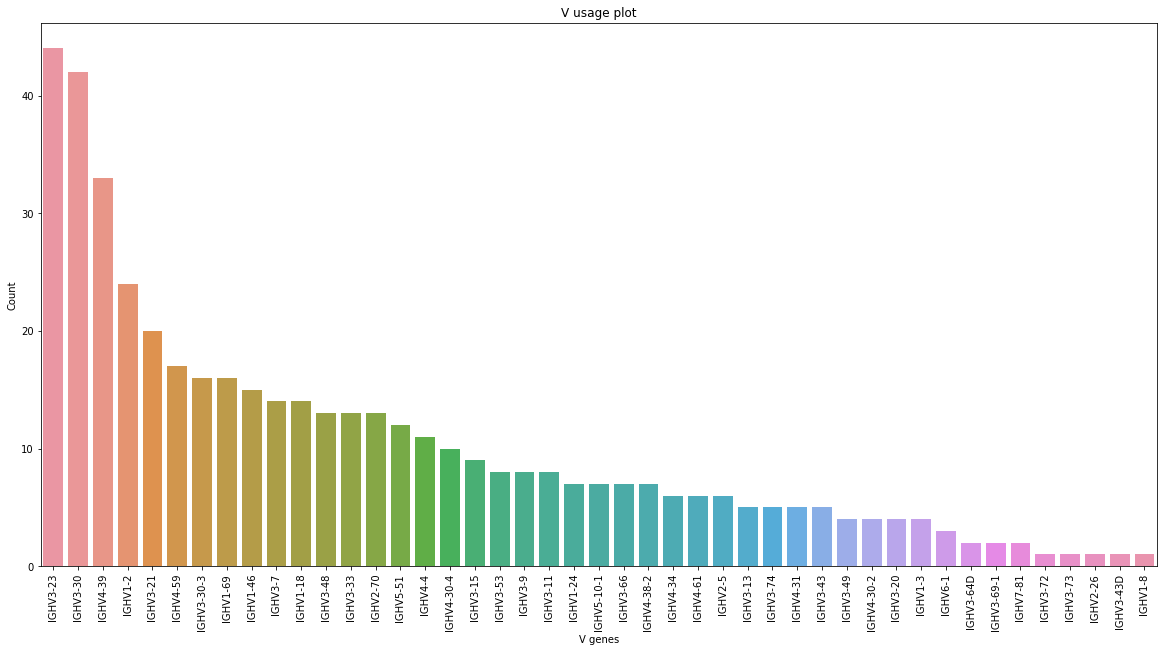

In [10]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation=90)
ax = sns.countplot(x='v_genes', data=cdr_v_usage, order=cdr_v_usage.v_genes.value_counts().index)
ax.set_title('V usage plot')
ax.set_xlabel('V genes')
ax.set_ylabel('Count')

# 5

In [11]:
with open('weblogo.fasta', 'w') as f:
    for i in lineages[0][1]:
        f.write(f'>{i}\n{cdr.loc[cdr.sequence_id == i].cdr3.values[0]}\n')

# 6

In [12]:
ids = lineages[0][1]

vdj_seqs = cdr.loc[cdr.sequence_id.isin(ids)][['sequence_id', 'sequence']]
with open('tree_vdj.fasta', 'w') as f:
    for row in vdj_seqs.itertuples():
        f.write(f'>{row.sequence_id}\n{row.sequence}\n')